## Work
1. 請嘗試將 preproc_x 替換成以每筆資料的 min/max 進行標準化至 -1 ~ 1 間，再進行訓練
2. 請嘗試將 mlp 疊更深 (e.g 5~10 層)，進行訓練後觀察 learning curve 的走勢
3. (optional) 請改用 GPU 進行訓練 (如果你有 GPU 的話)，比較使用 CPU 與 GPU 的訓練速度

In [1]:
## 確認硬體資源
#!nvidia-smi
from tensorflow.python.client import device_lib
device_lib.list_local_devices() 

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4085723527732002479]

In [2]:
import os
import keras

# Try to enable GPU (optional)
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))

    # 將 preproc_x 替換成以每筆資料的 min/max 進行標準化至 -1 ~ 1 間
    x = 2 * ((x - x.min()) / (x.max() - x.min())) - 1
    
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

print(f'x_train={x_train.shape}')
print(f'x_train[:2]={x_train[:2]}')
print(f'x_test={x_test.shape}')
print(f'x_test[:2]={x_test[:2]}')

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

print()
print(f'x_train={x_train.shape}')
print(f'x_train[:2]={x_train[:2]}')
print(f'x_test={x_test.shape}')
print(f'x_test[:2]={x_test[:2]}')

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

x_train=(50000, 32, 32, 3)
x_train[:2]=[[[[ 59  62  63]
   [ 43  46  45]
   [ 50  48  43]
   ...
   [158 132 108]
   [152 125 102]
   [148 124 103]]

  [[ 16  20  20]
   [  0   0   0]
   [ 18   8   0]
   ...
   [123  88  55]
   [119  83  50]
   [122  87  57]]

  [[ 25  24  21]
   [ 16   7   0]
   [ 49  27   8]
   ...
   [118  84  50]
   [120  84  50]
   [109  73  42]]

  ...

  [[208 170  96]
   [201 153  34]
   [198 161  26]
   ...
   [160 133  70]
   [ 56  31   7]
   [ 53  34  20]]

  [[180 139  96]
   [173 123  42]
   [186 144  30]
   ...
   [184 148  94]
   [ 97  62  34]
   [ 83  53  34]]

  [[177 144 116]
   [168 129  94]
   [179 142  87]
   ...
   [216 184 140]
   [151 118  84]
   [123  92  72]]]


 [[[154 177 187]
   [126 137 136]
   [105 104  95]
   ...
   [ 91  95  71]
   [ 87  90  71]
   [ 79  81  70]]

  [[140 160 169]
   [145 153 154]
   [125 125 118]
   ...
   [ 96  99  78]
   [ 77  80  62]
   [ 71  73  61]]

  [[140 155 164]
   [139 146 149]
   [115 115 112]
   ...
   [ 7

In [6]:
# 嘗試將 mlp 疊更深 (e.g 5~10 層)，進行訓練後觀察 learning curve 的走勢
#def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128, 64, 32]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
hidden_layer4 (Dense)        (None, 64)                8256      
_________________________________________________________________
hidden_layer5 (Dense)        (None, 32)                2080      
_________________________________________________________________
outp

In [8]:
## 超參數設定
LEARNING_RATE = 0.001
EPOCHS = 100
BATCH_SIZE = 256

In [9]:
optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

In [10]:
model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 21s 419us/step - loss: 1.7162 - acc: 0.3928 - val_loss: 1.5525 - val_acc: 0.4550
Epoch 2/100
50000/50000 [==============================] - 20s 392us/step - loss: 1.4839 - acc: 0.4782 - val_loss: 1.4472 - val_acc: 0.4873
Epoch 3/100
50000/50000 [==============================] - 20s 393us/step - loss: 1.3612 - acc: 0.5214 - val_loss: 1.4350 - val_acc: 0.4949
Epoch 4/100
50000/50000 [==============================] - 20s 397us/step - loss: 1.2774 - acc: 0.5506 - val_loss: 1.3941 - val_acc: 0.5066
Epoch 5/100
50000/50000 [==============================] - 20s 391us/step - loss: 1.1861 - acc: 0.5845 - val_loss: 1.3748 - val_acc: 0.5219
Epoch 6/100
50000/50000 [==============================] - 20s 393us/step - loss: 1.1096 - acc: 0.6099 - val_loss: 1.3754 - val_acc: 0.5269
Epoch 7/100
50000/50000 [==============================] - 20s

50000/50000 [==============================] - 19s 387us/step - loss: 0.0949 - acc: 0.9682 - val_loss: 3.7528 - val_acc: 0.5202
Epoch 58/100
50000/50000 [==============================] - 19s 377us/step - loss: 0.1027 - acc: 0.9671 - val_loss: 3.5813 - val_acc: 0.5308
Epoch 59/100
50000/50000 [==============================] - 19s 371us/step - loss: 0.1032 - acc: 0.9654 - val_loss: 3.7392 - val_acc: 0.5245
Epoch 60/100
50000/50000 [==============================] - 19s 385us/step - loss: 0.1135 - acc: 0.9628 - val_loss: 3.6034 - val_acc: 0.5246
Epoch 61/100
50000/50000 [==============================] - 20s 399us/step - loss: 0.0963 - acc: 0.9683 - val_loss: 3.7616 - val_acc: 0.5235
Epoch 62/100
50000/50000 [==============================] - 20s 400us/step - loss: 0.0941 - acc: 0.9698 - val_loss: 3.6615 - val_acc: 0.5360
Epoch 63/100
50000/50000 [==============================] - 21s 411us/step - loss: 0.0804 - acc: 0.9735 - val_loss: 3.7801 - val_acc: 0.5224
Epoch 64/100
50000/50000 [

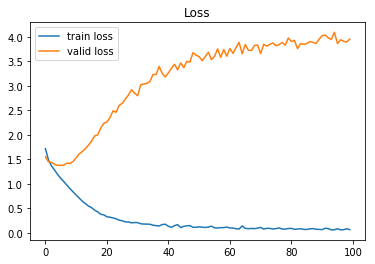

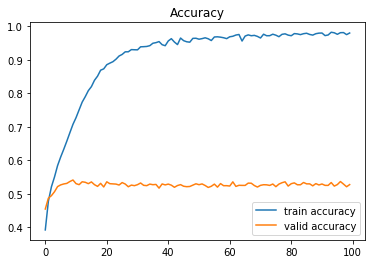

In [12]:
import matplotlib.pyplot as plt

train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]

train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()